In [2]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

## Prepare the dataset

In [3]:
# import the dataset
mnist = fetch_openml('mnist_784', version = 1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
# fetch the data
X = mnist["data"].values
y = mnist["target"].astype(np.uint8).values

In [5]:
# define function to print the images
def print_digit(index):
    example = X[index]
    example = example.reshape(28,28)
    plt.imshow(example, cmap='viridis')
    plt.axis('off')

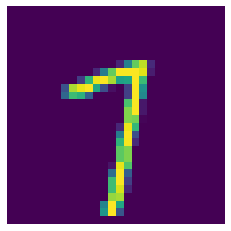

In [6]:
print_digit(42)

In [7]:
# split train test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Train set size:', X_train.shape)
print('Test set size:', X_test.shape)

Train set size: (56000, 784)
Test set size: (14000, 784)


## Shift images

In [8]:
from scipy.ndimage import shift

In [9]:
def shift_digit(img, vector, fill_with=0.0):
    img = img.reshape(28,28)
    img_shifted = shift(img, vector, cval=fill_with)
    
    # return unrolled image array
    return img_shifted.flatten()

In [10]:
# convert dataset into list for performance
X_train_boost = list(X_train)
y_train_boost = list(y_train)

In [11]:
shift_n = 0
image_n = 0
train_size_original = X_train.shape[0]

# loop through images and shift them
for (dx, dy) in ((1,0), (0,1), (-1,0), (0,-1)):
    shift_n += 1
    for image, label in zip(X_train, y_train):
        row_shifted = shift_digit(image, (dx, dy))
        
        # append shifted image and label
        X_train_boost.append(row_shifted)
        y_train_boost.append(label)
        
        print('Currently shifted: shift', shift_n, '/4', image_n, '/', train_size_original, end="\r") 
        image_n += 1
    
    

In [12]:
# convert back to np arrays
X_train_boost = np.array(X_train_boost)
y_train_boost = np.array(y_train_boost)

8


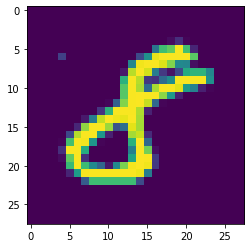

In [13]:
# check consistency of data augmentation
index = 250005
plt.imshow(X_train_boost[index].reshape(28,28))
print(y_train_boost[index])

## Develop a model

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [15]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
score = cross_val_score(clf, X_train, y_train, verbose=10, n_jobs=-1)
print(score)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   48.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.6min remaining:  1.0min


[0.96607143 0.96785714 0.96883929 0.96705357 0.96553571]


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.1min finished


In [16]:
clf = RandomForestClassifier(n_estimators=200, random_state=42)
score = cross_val_score(clf, X_train, y_train, verbose=4, n_jobs=-1)
print(score)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[0.96839286 0.96848214 0.97071429 0.96830357 0.96625   ]


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.3min finished


In [17]:
clf = RandomForestClassifier(random_state=42)
param_space = {'n_estimators': [100, 200], 'min_samples_split': range(2,8,2)}
grid = GridSearchCV(clf, param_grid=param_space, scoring="accuracy", n_jobs=-1, cv=5, verbose=4)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'min_samples_split': range(2, 8, 2),
                         'n_estimators': [100, 200]},
             scoring='accuracy', verbose=4)

In [18]:
grid.best_estimator_

RandomForestClassifier(n_estimators=200, random_state=42)

In [33]:
grid.best_params_

{'min_samples_split': 2, 'n_estimators': 200}

In [19]:
grid.best_score_

0.9684285714285714

In [20]:
model_noBoost = grid.best_estimator_

In [15]:
from sklearn.metrics import accuracy_score

In [22]:
y_pred = model_noBoost.predict(X_test)

In [23]:
accuracy_score(y_test, y_pred)

0.9681428571428572

In [24]:
model_noBoost.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [25]:
accuracy_score(y_test, model_noBoost.predict(X_test))

0.9681428571428572

In [26]:
#now on the boosted training set

In [27]:
clf_boost = grid.best_estimator_
clf_boost.fit(X_train_boost, y_train_boost)

RandomForestClassifier(n_estimators=200, random_state=42)

In [28]:
accuracy_score(y_test, clf_boost.predict(X_test))

0.9779285714285715

In [29]:
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(y_test, clf_boost.predict(X_test))
confusion


array([[1333,    0,    0,    0,    0,    0,    2,    1,    5,    2],
       [   0, 1579,    4,    5,    3,    1,    1,    4,    1,    2],
       [   2,    2, 1352,    3,    3,    0,    4,    5,    8,    1],
       [   1,    0,   19, 1379,    0,    7,    0,   13,   10,    4],
       [   3,    0,    2,    0, 1262,    0,    3,    3,    2,   20],
       [   1,    2,    2,   10,    1, 1240,    6,    1,    9,    1],
       [   2,    1,    0,    0,    1,    7, 1383,    0,    2,    0],
       [   1,    2,   11,    0,    4,    0,    0, 1470,    1,   14],
       [   0,    5,    7,    8,    2,    3,    3,    2, 1320,    7],
       [   3,    5,    2,   11,   12,    2,    1,    6,    5, 1373]])

<Figure size 1440x1440 with 0 Axes>

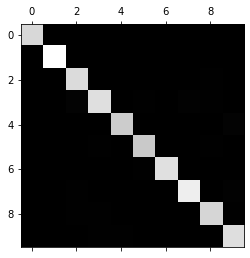

In [30]:
plt.figure(figsize=(20,20))
plt.matshow(confusion, cmap=plt.cm.gray)
plt.show()

In [31]:
import seaborn as sn

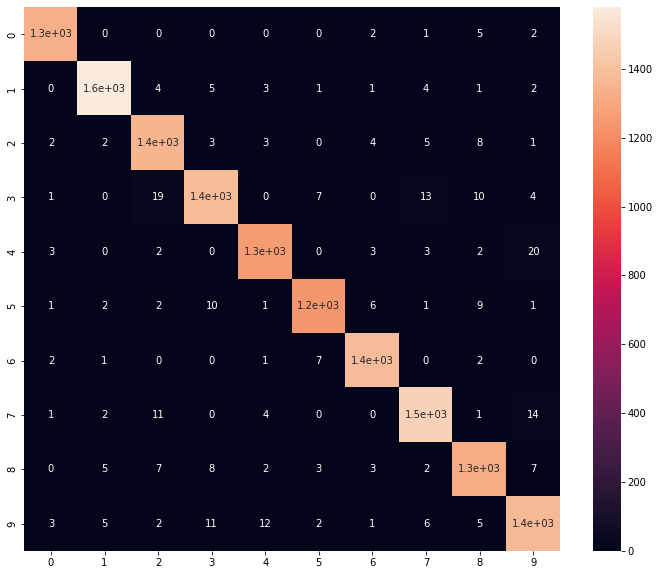

In [32]:
plt.figure(figsize = (12,10))
sn.heatmap(confusion, annot=True)

In [ ]:
# try improving random forest with better gridsearch
clf = RandomForestClassifier(random_state=42)
param_space = {'n_estimators': [200, 300], 'max_features':[None, 'auto'], 'min_samples_split': range(2,6,2)}
grid2 = GridSearchCV(clf, param_grid=param_space, scoring="accuracy", n_jobs=-1, cv=5, verbose=4)
grid2.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [ ]:
classifier = RandomForestClassifier(random_state=42)
parameter_space = {'max_depth': [2,3,4,5]}
grid_search = GridSearchCV(classifier, parameter_space, cv=5, scoring="accuracy", return_train_score=True, verbose=3)

grid_search.fit(X_train_boost, y_train_boost)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ....................................max_depth=2; total time= 1.7min
[CV 2/5] END ....................................max_depth=2; total time= 1.4min
[CV 3/5] END ....................................max_depth=2; total time= 1.5min
[CV 4/5] END ....................................max_depth=2; total time= 1.4min
[CV 5/5] END ....................................max_depth=2; total time= 1.4min
[CV 1/5] END ....................................max_depth=3; total time= 2.5min
[CV 2/5] END ....................................max_depth=3; total time= 2.1min
[CV 3/5] END ....................................max_depth=3; total time= 2.1min
[CV 4/5] END ....................................max_depth=3; total time= 2.0min
[CV 5/5] END ....................................max_depth=3; total time= 2.0min
[CV 1/5] END ....................................max_depth=4; total time= 3.2min
[CV 2/5] END ....................................

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [2, 3, 4, 5]}, return_train_score=True,
             scoring='accuracy', verbose=3)

In [ ]:
best_model = grid_search.best_estimator_
best_model

RandomForestClassifier(max_depth=5, random_state=42)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train_boost, y_train_boost)

DecisionTreeClassifier(random_state=42)

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_boosted = accuracy_score(y_test, clf.predict(X_test))
print("Accuracy score with boosted dataset:", accuracy_boosted)

Accuracy score with boosted dataset: 0.908


In [ ]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [ ]:
accuracy_boosted = accuracy_score(y_test, clf.predict(X_test))
print("Accuracy score with boosted dataset:", accuracy_boosted)

Accuracy score with boosted dataset: 0.8695
